In [ ]:
!pip install --upgrade pip
!pip install pandas pyyaml openpyxl
!pip install loguru

# Конвертация таблиц excel к формату *.yaml.

### Пример итогового *.yaml файла:

```
version: 1
source: DataHub
owners:
    users:
        - Ivan Ivanov
        - Elon Musk
    groups: Documents
url: https://www.google.com
nodes:
    - name: Buisness
      description: Some buisness terms
      knowledge_links:
          label: Wiki
          url: "https://en.wikipedia.org/"
    owners:
        users: Peter Parker
    custom_properties:
        is_confidential: true
    terms:
        - name: Account
          description: Container for records associated with a business arrangement for regular transactions and services
          term_source: "EXTERNAL"
          source_ref: FIBO
        - name: FullAddress
          description: A collection of information to give the location of a building or plot of land.
...
...
```

### Пример excel таблицы

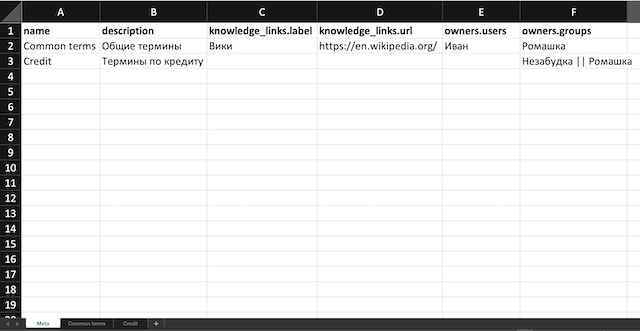 | 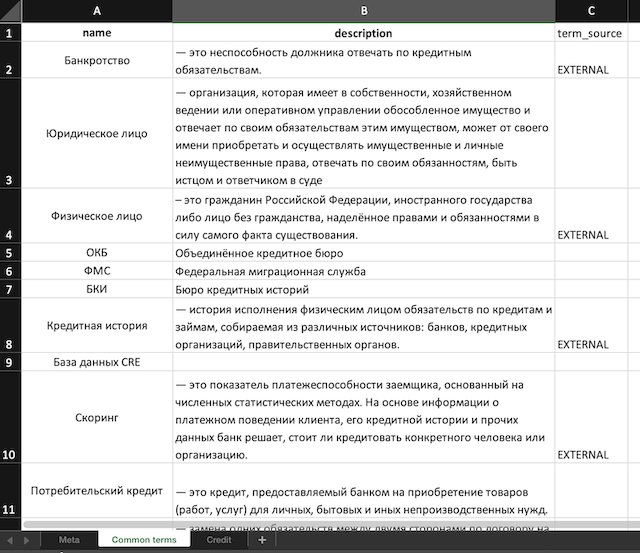 | 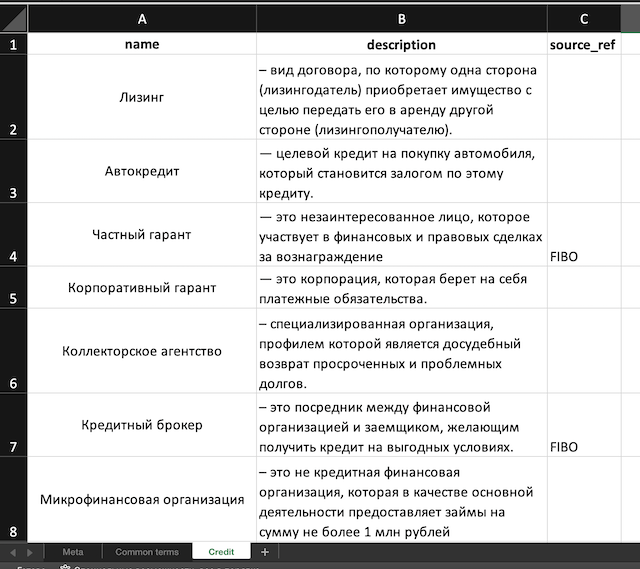


### Требования к excel
Данные считываются из excel таблицы. Общая информация о глоссарии запрашивается у пользователя и вводится вручную (**version**, **source**, **owners**, **url**).

Термины сгруппированы по листам. Обязательно присутствие листа, который содержит метаданные по каждой группе (**name**, **description** и т.д.). По умолчанию этот лист имеет имя *Meta*, однако его можно указать вручную конвертеру. Название группы (**name**) в метаданных должно совпадать с именами листов, содержащих соответствующие группы.

Первая строка каждого excel листа содержит имена для генерации соответствующих полей в \**.yaml* файле. Их формат может меняться. Допускается вложенность (разделяется через точку, например **owners.users**). Значения соответствующих полей допускают перечисления через заданный разделитель (по умолчанию ```||```).



In [1]:
import pandas as pd
import numpy as np
import openpyxl
import yaml

from loguru import logger

In [4]:
from loguru import logger


class Converter:
    """ Класс для преобразования excel таблиц к формату *.yaml

    Точка входа — метод convert.
    """

    def __init__(self):
        self.df = None
        self.sep = None

    def _read_sheet(self, sheet_name: str) -> list[dict]:
        """ Прочитать и обработать данные с заданного листа в документе

        :param sheet_name: имя листа, откуда считать данные
        :return: список словарей с обработанными данными
        """

        logger.info(f"Reading {sheet_name} sheet..")
        raw_sheet_data = self.df[sheet_name].to_dict(orient="records")
        logger.info(f"Processing {sheet_name} sheet data..")
        processed_sheet_data = [self._process_sheet_data(data) for data in raw_sheet_data]
        return processed_sheet_data

    def _process_sheet_data(self, data: dict) -> dict:
        """ Обработка (очистка, форматирование) считанных данных

        :param data: словарь с сырыми данными
        :return: словарь с обработанными данными
        """

        new_dict = {}
        for k, v in data.items():
            if v is None or v is np.nan:  # Пропускаем незаполненные поля
                continue

            new_key = k.split(".")
            # Исходная строка или список строк, разбитых по разделителю
            new_value = list(map(str.strip, v.split(self.sep)))
            new_value = new_value if len(new_value) != 1 else new_value[0]

            # Разбиваем записи вида {key1.key2.key3: value} на {key1: {key2: {key3: value}}}
            current_dict = new_dict
            while len(new_key) > 1:
                current_dict.setdefault(new_key[0], {})
                current_dict = current_dict[new_key[0]]
                new_key = new_key[1:]
            current_dict[new_key[0]] = new_value
        return new_dict

    def _make_header(self,
                     version,
                     source,
                     url,
                     owners_user: list[str]=None,
                     owners_group: list[str]=None) -> dict:
        """ Заполнить информацию про документ.
        У документа должен быть хотя бы один владелец (группа).

        :return: словарь с заголовком документа
        """

        if not owners_group and not owners_user:
            logger.error("Должен быть указан хотя бы один владелец")
        header = {
            "version": version,
            "source": source,
            "url": url,
            "owners": {}
        }
        if owners_group:
            header["owners"]["groups"] = owners_group
        if owners_user:
            header["owners"]["users"] = owners_user
        return header

    def _to_yaml(self, data: dict, filename: str) -> None:
        """ Записать данные в файл *.yaml

        :param data: данные для записи
        :param filename: имя файла
        :return: None
        """
        logger.info(f"Done. Writing results to {filename}..")
        with open(filename, "w") as f:
            yaml.dump(data, f, allow_unicode=True, sort_keys=False)

    def convert(self,
                excel_filename: str,
                yaml_filename: str,
                version: int | str,
                source: str,
                url: str,
                owners_user: list[str]=None,
                owners_group: list[str]=None,
                meta_sheet_name="Meta",
                separator: str="||") -> None:
        """ Выполнить преобразование excel таблицы к формату *.yaml
        У документа должен быть хотя бы один владелец (группа).
        Структура excel таблицы заранее известна и соответствует некоторым требованиям.

        :param excel_filename: имя excel таблицы
        :param yaml_filename: имя *.yaml файла
        :param version: версия документа
        :param source: источник документа
        :param url: ссылка на документ
        :param owners_user: полозователи, владеющие документом
        :param owners_group: группы, к которым принадлежит документ
        :param meta_sheet_name: имя листа, с метаданными ("Meta" по умолчанию)
        :param separator: разделитель при перечислении в ячейках excel ("||" по умолчанию)
        :return: None
        """

        logger.info(f"Reading {excel_filename}..")
        self.df = pd.read_excel(excel_filename, sheet_name=None)
        self.sep = separator

        header = self._make_header(version, source, url, owners_user, owners_group)
        data_dict = {**header, "nodes": []}
        meta = self._read_sheet(meta_sheet_name)
        for sheet_meta in meta:
            terms_sheet = self._read_sheet(sheet_meta["name"])
            data_dict["nodes"].append({**sheet_meta, "terms": terms_sheet})
        self._to_yaml(data_dict, yaml_filename)

In [5]:
version = input("Укажите версию документа: ")
source = input("Укажите источник документа: ")
url = input("Укажите ссылку на документ: ")
owners_user = input("Перечислите владельцев документа через пробел (пользователи): ").split()
owners_group = input("Перечислите владельцев документа через пробел (группы): ").split()
excel_filename = input("Укажите имя excel таблицы: ")
yaml_filename = input("Укажите имя *.yaml файла: ")

converter = Converter()
converter.convert(excel_filename, yaml_filename, version, source, url, owners_user, owners_group)

2023-08-08 15:57:35.183 | INFO     | __main__:convert:116 - Reading glossary.xlsx..
2023-08-08 15:57:35.198 | INFO     | __main__:convert:122 - Reading meta sheet..
2023-08-08 15:57:35.198 | INFO     | __main__:_read_sheet:21 - Reading Meta sheet..
2023-08-08 15:57:35.200 | INFO     | __main__:_read_sheet:23 - Processing Meta sheet data..
2023-08-08 15:57:35.200 | INFO     | __main__:_read_sheet:21 - Reading Common terms sheet..
2023-08-08 15:57:35.201 | INFO     | __main__:_read_sheet:23 - Processing Common terms sheet data..
2023-08-08 15:57:35.202 | INFO     | __main__:_read_sheet:21 - Reading Credit sheet..
2023-08-08 15:57:35.202 | INFO     | __main__:_read_sheet:23 - Processing Credit sheet data..
2023-08-08 15:57:35.203 | INFO     | __main__:_to_yaml:86 - Done. Writing results to glossary.yaml..


In [11]:
!cat {yaml_filename}

version: '0.2'
source: Источник
url: какая то ссылка
owners:
  groups:
  - группа1
  - группа2
  users:
  - я
  - он
nodes:
- name: Common terms
  description: Общие термины
  knowledge_links:
    label: Вики
    url: https://en.wikipedia.org/
  owners:
    users: Иван
    groups: Ромашка
  terms:
  - name: Банкротство
    description: — это неспособность должника отвечать по кредитным обязательствам.
    term_source: EXTERNAL
  - name: Юридическое лицо
    description: — организация, которая имеет в собственности, хозяйственном ведении
      или оперативном управлении обособленное имущество и отвечает по своим обязательствам
      этим имуществом, может от своего имени приобретать и осуществлять имущественные
      и личные неимущественные права, отвечать по своим обязанностям, быть истцом
      и ответчиком в суде
  - name: Физическое лицо
    description: – это гражданин Российской Федерации, иностранного государства либо
      лицо без гражданства, наделённое правами и обязанностям